# APS1070
#### Basic Principles and Models - Project 1
**Deadline: Oct 1, 9PM - 10 percent**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Name: Zhaowei Li

Student ID: 1007911994

##**Marking Scheme:**

This project is worth **10 percent** of your final grade.

Draw a plot or table where necessary to summarize your findings. 

**Practice Vectorized coding**: If you need to write a loop in your solution, think about how you can implement the same functionality with vectorized operations. Try to avoid loops as much as possible (in some cases, loops are inevitable).


 <font color='red'>**Remember to push your work on GitHub and share the link of your private repo on Quercus.**</font> 




# Project 1 [10 Marks] 
Let's apply the tools we have learned in the tutorial to a new dataset.

We're going to work with a breast cancer dataset. Download it using the cell below:

In [47]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

## Part 1: Getting started [2 Marks]
First off, take a look at the `data`, `target` and `feature_names` entries in the `dataset` dictionary. They contain the information we'll be working with here. Then, create a Pandas DataFrame called `df` containing the data and the targets, with the feature names as column headings. If you need help, see [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for more details on how to achieve this. **[0.4]**
* How many features do we have in this dataset? 30
* How many observations have a 'mean area' of greater than 700? 171
* How many participants tested `Malignant`? 212
* How many participants tested `Benign`? 357

In [48]:
import pandas as pd

feature_data = dataset.data
feature_names = dataset.feature_names
target_data = dataset.target
target_names = dataset.target_names

df = pd.DataFrame(feature_data, columns=feature_names)
df["target"] = target_data

num_features = len(feature_names)
obs_meanarea_g700 = len(df["mean area"][df["mean area"] > 700])
num_mal = len(df["target"][df["target"] == 0])
num_ben = len(df["target"][df["target"] == 1])

print(num_features)
print(obs_meanarea_g700)
print(num_mal)
print(num_ben)


30
171
212
357


### Splitting the data
It is best practice to have a training set (from which there is a rotating validation subset) and a test set. Our aim here is to (eventually) obtain the best accuracy we can on the test set (we'll do all our tuning on the training/validation sets, however.) 

**Split the dataset** into a train and a test set **"70:30"**, use **``random_state=0``**. The test set is set aside (untouched) for final evaluation, once hyperparameter optimization is complete. **[0.5]**

In [49]:
### YOUR CODE HERE ###
data_processed = df.values

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(data_processed[:,0:-1],data_processed[:,-1],test_size=0.3, random_state=0) #"target" column is at the -1 position 


### Effect of Standardization (Visual)
Use `seaborn.lmplot` ([help here](https://seaborn.pydata.org/generated/seaborn.lmplot.html)) to visualize a few features of the training set. Draw a plot where the x-axis is ``worst smoothness``, the y-axis is ``worst fractal dimension,`` and the color of each datapoint indicates its class.  **[0.5]**

Standardizing the data is often critical in machine learning. Show a plot as above, but with two features with very different scales. Standardize the data and plot those features again. What's different? Based on your observation, what is the advantage of standardization? **[0.6]**




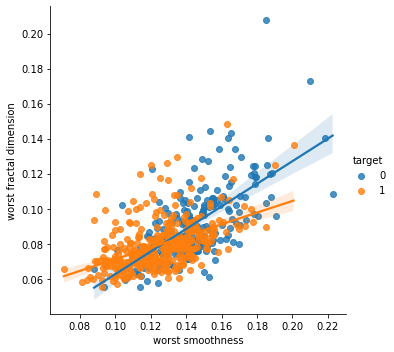

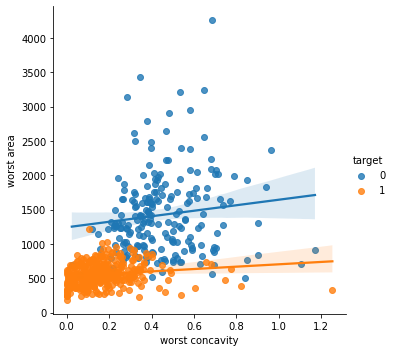

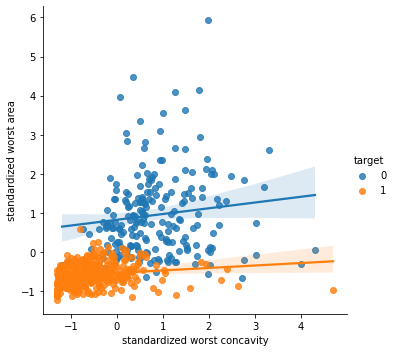

In [50]:
### YOUR CODE HERE ###
import seaborn as sns

def standardize(i):
  me,st = i.mean(), i.std()
  stan = (i-me)/st

  return stan

sns.lmplot(x="worst smoothness", y="worst fractal dimension", data=df, hue="target")

sns.lmplot(x="worst concavity", y="worst area", data=df, hue="target")

stan_w_con = standardize(df["worst concavity"])
stan_w_are = standardize(df["worst area"])

stan_2_df = pd.concat([stan_w_con, stan_w_are,df["target"]], axis=1)

stan_2_df.columns = ["standardized worst concavity","standardized worst area","target"]

sns.lmplot(x="standardized worst concavity", y="standardized worst area", data=stan_2_df, hue="target")


There is no obvious difference between the graphs that before and after standardization, except the scales become same on both axises. So, the advantage of the standardization is to reserve the distribution of features' data while making all features's data more even. It is definitely helpful in model training, since we want to aviod some features to be more dominant than others just by the size of the numbers.

## Part 2: KNN Classifier without Standardization [2 Marks]
Normally, standardizing data is a key step in preparing data for a KNN classifier. However, for educational purposes, let's first try to build a model without standardization. Let's create a KNN classifier to predict whether a patient has a malignant or benign tumor. 

Follow these steps: 

1.   Train a KNN Classifier using cross-validation on the dataset. Sweep `k` (number of neighbours) from 1 to 100, and show a plot of the mean cross-validation accuracy vs `k`. **[1]**
2.   What is the best `k`? What is the highest cross-validation accuracy? **[0.5]**
3. Comment on  which ranges of `k` lead to underfitted or overfitted models (hint: compare training and validation curves!). **[0.5]**




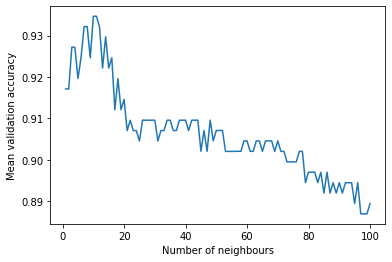

Number of neighbours        10.000000
Mean validation accuracy     0.934652
Mean train accuracy          0.934039
Name: 9, dtype: float64


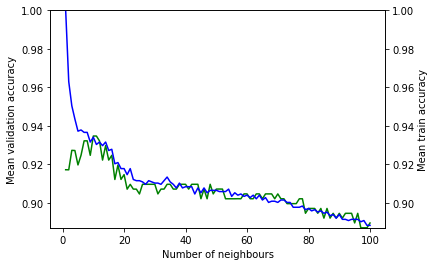

In [51]:
### YOUR CODE HERE ###
#1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

testscore_lst = list()
trainscore_lst = list()
k_lst = list()

for i in range(1,101):
  knn = KNeighborsClassifier(n_neighbors=i)

  knn.fit(x_train, y_train)

  scores = cross_validate(knn, x_train, y_train, return_train_score=True)
  trainscore_lst.append(scores["train_score"].mean())
  testscore_lst.append(scores["test_score"].mean())
  k_lst.append(i)

comb_lst = list()
comb_lst.extend([k_lst, testscore_lst, trainscore_lst])

knn_df = pd.DataFrame(data=comb_lst).transpose()
knn_df.columns = ["Number of neighbours", "Mean validation accuracy", "Mean train accuracy"]

sns.lineplot(x="Number of neighbours", y="Mean validation accuracy", data=knn_df)
plt.show()

#2
max_index = knn_df["Mean validation accuracy"].idxmax()
print(knn_df.loc[max_index])

#3
min_tr_acc = knn_df["Mean train accuracy"].min()
min_val_acc =  knn_df["Mean validation accuracy"].min()
if min_tr_acc > min_val_acc:
  min_scale = min_val_acc
else:
  min_scale = min_tr_acc

a_plot = sns.lineplot(x="Number of neighbours", y="Mean validation accuracy", data=knn_df, color="g")
a_plot.set(ylim=(min_scale,1))
ax2 = plt.twinx()
b_plot = sns.lineplot(x="Number of neighbours", y="Mean train accuracy", data=knn_df, color="b", ax=ax2)
b_plot.set(ylim=(min_scale,1))
plt.show()



2. The best k is 10, and the highest mean cross_validation accuracy is 0.934652.
3. Between k = 0 and k = 10, it leads to overfitted model. The mean train accuracy is significantly higher than the mean validation accuracy, which means low train error and high validation error.
Between k = 30 and k = 100 , it leads to underfitted model. Both accuracies are declining, which means higher train error and higher validation error.

## Part 3: Feature Selection [4 Marks]
In this part, we aim to investigate the importance of each feature on the final classification accuracy. 
If we want to try every possible combination of features, we would have to test  $2^F$ different cases,  where F is the number of features, and in each case, we have to do a hyperparameter search (finding K, in KNN using cross-validation). That will take days!. 

To find more important features we will use a decision tree. based on a decision tree we can compute feature importance that is a metric for our feature selection (code is provided below).

You can use the following link to get familiar with extracting the feature impotance order of machine learning algorithms in Python: 

https://machinelearningmastery.com/calculate-feature-importance-with-python/

After we identified and removed the least important feature and evaluated a new KNN model on the new set of features, if the stop conditions (see step 7 below) are not met, we need to remove another feature. To do that we fit a new decision tree to the remaining features and identify the least important feature. 


Design a function ( `Feature_selector`) that accepts your dataset (X_train , y_train) and a threshold as inputs and: **[3]**
1. Fits a decision tree classifier on the training set.

2. Extracts the feature importance order of the decision tree model.

3. Each time, removes the least important feature based on step 2. 
4. Then, a KNN model is trained on the remaining features. The number of neighbors (`k`) for each KNN model should be tuned using a 5-fold cross-validation.
5. Store the best `mean cross-validation` score and the corresponding `k` (number of neighbours) value in two lists.
6. Go back to step 1, fit a new tree on the reduced dataset and follow all the steps until you meet the stop condition. 
 
7. We will stop this process when (1) there is only one feature left, or (2) our cross-validation accuracy is dropped significantly compared to a model that uses all the features. In this function, we accept a threshold as an input argument. For example, if threshold=0.95 we do not continue removing features if our mean cross-validation accuracy after tuning `k` is bellow **0.95 $\times$ Full Feature cross-validation accuracy**.

8. Your function returns the list of removed features, and the corresponding mean cross-validation accuracy and `k` value when a feature was removed.

* Visualize your results by plotting the mean cross-validation accuracy (with a tuned `k` on y axis) vs. the number of features (x axis). This plot describes: what is the best cv score with 1 feature, 2 features, 3 features ... and all the features. **[0.5]**

* Plot the best value of `k` (y-axis) vs. the number of features. This plot explains the trend of number of neighbours with respect to the number of features.  **[0.5]**

  
  







 

You can use the following piece of code to start training a decision tree classifier and obtain its feature importance order. 
```
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
importance = dt.feature_importances_
```


In [52]:
from sklearn import tree
import numpy as np

max_val_full = knn_df["Mean validation accuracy"].max()


def Feature_selector (x_train , y_train , tr=0.95):
### YOUR CODE HERE ###
  global max_val_full
  global feature_names
  max_val = 1
  feature_names_exp = feature_names 
  rem_fea_name_lst = list()
  best_mean_acc_lst = list()
  num_nei_lst = list()
  x_train_df = pd.DataFrame(data=x_train)
  
  while max_val > (tr*max_val_full):
    dt = tree.DecisionTreeClassifier()
    dt.fit(x_train,y_train)
    importance = dt.feature_importances_

    if len(importance) == 1:
      break
    else:
      min_index = importance.argmin()

      x_train_df.drop(x_train_df.columns[min_index], axis=1, inplace=True)
      x_train = x_train_df.values

      testscore_lst = list()
      k_lst = list()

      for i in range(1,101):
        knn = KNeighborsClassifier(n_neighbors=i)

        knn.fit(x_train, y_train)

        scores = cross_validate(knn, x_train, y_train)
        testscore_lst.append(scores["test_score"].mean())
        k_lst.append(i)

      max_val = max(testscore_lst)
      max_val_index = testscore_lst.index(max_val)

      rem_fea_name_lst.append(feature_names_exp[min_index])
      feature_names_exp = np.delete(feature_names_exp,min_index)
      best_mean_acc_lst.append(max_val)
      num_nei_lst.append(k_lst[max_val_index])

  return rem_fea_name_lst, best_mean_acc_lst, num_nei_lst

rem_fea_name_lst, best_mean_acc_lst, num_nei_lst = Feature_selector(x_train,y_train)



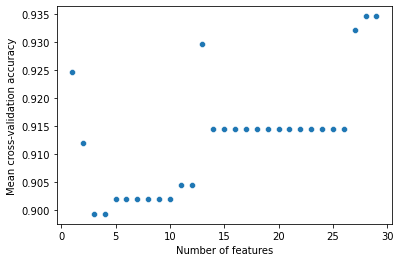

In [53]:
num_features_lst = list()

for i in range(1,len(rem_fea_name_lst)+1):
  num_features_lst.append(30-i)

num_features_lst

part3_dct = {"Number of features": num_features_lst, "Removed feature": rem_fea_name_lst, "Mean cross-validation accuracy": best_mean_acc_lst, "Number of neighbors": num_nei_lst}
part3_df = pd.DataFrame(part3_dct)

sns.scatterplot(x="Number of features",y="Mean cross-validation accuracy",data=part3_df)


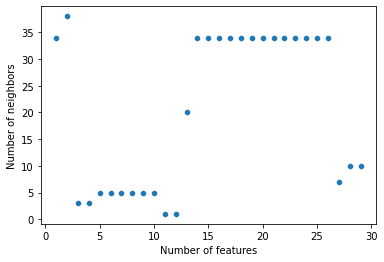

In [54]:
sns.scatterplot(x="Number of features",y="Number of neighbors",data=part3_df)

## Part 4: Standardization [1.5 Marks]

Standardizing the data usually means scaling our data to have a mean of zero and a standard deviation of one. 

**Note:** When we standardize a dataset, do we care if the data points are in our training set or test set? Yes! The training set is available for us to train a model - we can use it however we want. The test set, however, represents a subset of data that is not available for us during training. For example, the test set can represent the data that someone who bought our model would use to see how the model performs (which they are not willing to share with us).
Therefore, we cannot compute the mean or standard deviation of the whole dataset to standardize it - we can only calculate the mean and standard deviation of the training set. However, when we sell a model to someone, we can say what our scalers (mean and standard deviation of our training set) was. They can scale their data (test set) with our training set's mean and standard deviation. Of course, there is no guarantee that the test set would have a mean of zero and a standard deviation of one, but it should work fine.

**To summarize: We fit the StandardScaler only on the training set. We transform both training and test sets with that scaler.**

1. Standardize the training  and test data ([Help](https://scikit-learn.org/stable/modules/preprocessing.html)) **[0.5]**

2. Call your ``Feature_selector`` function on the standardized training data with a threshold of 0.95\%.  **[0.5]**
 * Plot the Cross validation accuracy when we have the standardized data (this part) and the original training data (last part) vs. the Number of features in a single plot (to compare them easily).

3. Discuss how standardization (helped/hurt) your model and its performance? Discuss which cases lead to a higher cross validation accuracy (how many features? which features? What K?) **[0.5]**


In [55]:
### YOUR CODE HERE ###
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(x_train)

#1
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
#

testscore_lst = list()

for i in range(1,101):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(x_train, y_train)
  scores = cross_validate(knn, x_train, y_train)
  testscore_lst.append(scores["test_score"].mean())

max_val_full = max(testscore_lst)

st_rem_fea_name_lst, st_best_mean_acc_lst, st_num_nei_lst = Feature_selector(x_train,y_train)





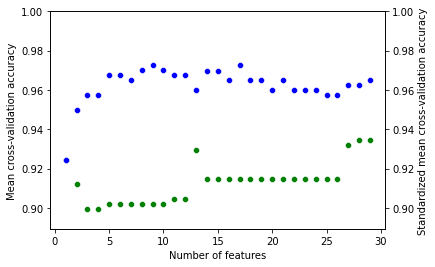

Number of features                                      29
Removed feature                                mean radius
Mean cross-validation accuracy                    0.934652
Number of neighbors                                     10
Standardized removed feature                   mean radius
Standardized mean cross-validation accuracy       0.964968
Standardized number of neighbors                         8
Name: 0, dtype: object 

Number of features                                            17
Removed feature                                compactness error
Mean cross-validation accuracy                          0.914589
Number of neighbors                                           34
Standardized removed feature                    smoothness error
Standardized mean cross-validation accuracy             0.972468
Standardized number of neighbors                               8
Name: 12, dtype: object 

['mean radius', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactne

In [56]:
part4_df = part3_df.copy()
part4_df["Standardized removed feature"] = st_rem_fea_name_lst
part4_df["Standardized mean cross-validation accuracy"] = st_best_mean_acc_lst
part4_df["Standardized number of neighbors"] = st_num_nei_lst

part4_min_acc = part4_df["Mean cross-validation accuracy"].min()
part4_min_st_acc =  part4_df["Standardized mean cross-validation accuracy"].min()
if part4_min_acc > part4_min_st_acc:
  part4_min_scale = part4_min_st_acc
else:
  part4_min_scale = part4_min_acc

c_plot = sns.scatterplot(x="Number of features", y="Mean cross-validation accuracy", data=part4_df, color="g")
c_plot.set(ylim=(part4_min_scale-0.01,1))
part4_ax2 = plt.twinx()
d_plot = sns.scatterplot(x="Number of features", y="Standardized mean cross-validation accuracy", data=part4_df, color="b", ax=part4_ax2)
d_plot.set(ylim=(part4_min_scale-0.01,1))
plt.show()

part4_max_index = part4_df["Mean cross-validation accuracy"].idxmax()
print(part4_df.loc[part4_max_index],"\n")

part4_max_index_st = part4_df["Standardized mean cross-validation accuracy"].idxmax()
print(part4_df.loc[part4_max_index_st],"\n")

part4_rem_fea_nam_lst = list(part4_df["Standardized removed feature"][:part4_max_index_st+1])
print(part4_rem_fea_nam_lst, "\n",
      len(part4_rem_fea_nam_lst))


3. Base on the graph, generally, the accuracy after standardization is higher than before on every level of number of features. Hence, the standardization definitly improves the model and its performace by making all features' data be more even to reduce the possible noises, that can be caused by the different scales of features' data. 

Hence, the standardized case leads to higher cross validation accuracy.

(The first block above is the row where locates highest mean cross validation accuracy.
The second block above is the row where locates highest standardized mean cross validation accuracy.)

The corresponding neighbors can be finded in the second block. The removed feature names and the number of them can be found in the last line above.




## Part 5: Test Data [0.5 Mark]

Now that you've created several models, pick your best one (highest CV accuracy) and apply it to the test dataset you had initially set aside. Discuss your results. **[0.5]**

In [57]:
### YOUR CODE HERE ###
part5_df = part4_df.copy()

part5_max_index = part5_df["Standardized mean cross-validation accuracy"].idxmax()

part5_rem_fea_nam_lst = list(part5_df["Standardized removed feature"][:part5_max_index+1])
part5_knn_nei = part5_df["Standardized number of neighbors"][part5_max_index]

x_train_df = pd.DataFrame(data=x_train, columns=feature_names)
x_train_df.drop(part5_rem_fea_nam_lst, axis=1, inplace=True)
x_train = x_train_df.values

x_test_df = pd.DataFrame(data=x_test, columns=feature_names)
x_test_df.drop(part5_rem_fea_nam_lst, axis=1, inplace=True)
x_test = x_test_df.values






In [58]:
part5_knn = KNeighborsClassifier(n_neighbors=part5_knn_nei)
part5_knn.fit(x_train, y_train)

train_predicted = part5_knn.predict(x_train)
final_train_score = 100*(1-sum(abs(train_predicted-y_train))/len(train_predicted))
print('Training data performance', final_train_score, '% correctly predicted')

test_predicted = part5_knn.predict(x_test)
final_test_score = 100*(1-sum(abs(test_predicted-y_test))/len(test_predicted))
print("Test data performance", final_test_score,'% correctly predicted')


Training data performance 97.48743718592965 % correctly predicted
Test data performance 94.73684210526316 % correctly predicted


The result is satisfied for the test. Both train dataset and test dataset has a high performance to aviod to be underfitted, and they have a small difference to aviod to be overfitted. 

References:

https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

https://www.analyticsvidhya.com/blog/2021/02/machine-learning-101-decision-tree-algorithm-for-classification/